In [1]:
# !python --version

In [1]:
import os
from dotenv import load_dotenv
import psycopg
import pandas as pd
import numpy as np
from datetime import timedelta
from sqlalchemy import create_engine
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier



# Load environment variables from .env file
load_dotenv()

# Global schema variable.
SCHEMA = "pm_ncr_pf_v1"

# Database connection details
DB_CONFIG = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT")
}

# Create SQLAlchemy connection string

if DB_CONFIG['password']:
    DB_URI = f"postgresql+psycopg://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
else:
    DB_URI = f"postgresql+psycopg://{DB_CONFIG['user']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"


# === SQL Query to fetch top observations ===
QUERY = f"""
WITH top_obs AS (
  SELECT 
    *, 
    ROW_NUMBER() OVER (PARTITION BY product_family ORDER BY num_devices DESC) AS rank  -- CHANGE FOR PF: Partition by PF
  FROM {SCHEMA}.obs_stats
  WHERE product_family IS NOT NULL  -- CHANGE FOR PF: Filter out null PF
)
SELECT 
    cases.serial_number AS device,
    cases.case_id,
    cases.created_date,
    cases.last_modified_date,
    cases.observation AS problem,
    cases.case_obs_created_date,
    cases.observation_id,
    cases.module,
    cases.product_family,
    inference_id,
    inference_created_date,
    sr_number
FROM {SCHEMA}.case_obs AS cases
INNER JOIN top_obs 
  ON cases.observation_id = top_obs.observation_id 
  AND cases.product_family = top_obs.product_family  -- CHANGE FOR PF: Join on PF
WHERE top_obs.rank <= 200  -- Top 100 per PF
"""


def fetch_data():
    """Fetch data from the PostgreSQL database using SQLAlchemy."""
    print(f" Connecting to DB_URI: {DB_URI}")
    engine = create_engine(DB_URI)
    df = pd.read_sql_query(QUERY, engine)
    df["case_obs_created_date"] = pd.to_datetime(df["case_obs_created_date"], errors='coerce')
    df["last_modified_date"] = pd.to_datetime(df["last_modified_date"], errors='coerce')
    df["created_date"] = pd.to_datetime(df["created_date"], errors='coerce')
    df["inference_created_date"] = pd.to_datetime(df["inference_created_date"], errors='coerce')

    # Calculate dwell time
    df["dwell_time_seconds"] = (df["last_modified_date"] - df["created_date"]).dt.total_seconds()
    
    # Sort by device and timestamp for proper pairing.
    df = df.sort_values(by=["device", "case_obs_created_date"]).reset_index(drop=True)
    return df

In [2]:
os.getcwd()

'/Users/nitish.rathour/Documents/PM_git/PDM'

In [ ]:
# fetching data for top 100 observations per product family
n7data = pd.read_csv('../ncr_all_data.csv',usecols=['created_date', 'sr_number', 'country', 'serial_number', 'last_modified_date'])
n7data.head()

,created_date,sr_number,country,serial_number,last_modified_date
0,2024-10-20 09:07:21.774,7429403364,TH,94-52701598,2024-10-20 09:08:37.149
1,2025-05-31 13:40:21.28,7515114395,CA,57-55554084,2025-05-31 13:40:51.388
2,2025-05-31 13:40:21.28,7515114395,CA,57-55554084,2025-05-31 13:40:51.388
3,2024-12-20 23:18:26.973,7435404833,MX,94-61354017,2024-12-20 23:18:38.153
4,2025-05-31 13:40:21.28,7515114395,CA,57-55554084,2025-05-31 13:40:51.388


In [5]:
n7data['last_modified_date'] = pd.to_datetime(n7data['last_modified_date'], errors='coerce')
n7data['created_date'] = pd.to_datetime(n7data['created_date'], errors='coerce')
print(n7data['last_modified_date'].min(), n7data['last_modified_date'].max())
print(n7data['created_date'].min(), n7data['created_date'].max())

2023-08-08 13:12:33.251000 2025-07-28 05:30:00.599000
2023-08-08 13:12:33.251000 2025-07-28 05:30:00.599000


In [6]:
# n7data_us = n7data[(n7data['country']=='US') & (n7data['serial_number'].notna()) & (n7data['sr_number'].notna())]
# n7data_us.shape, n7data_us['serial_number'].nunique(), n7data_us['sr_number'].nunique()

In [7]:
n7data.isna().sum()

created_date            5681
sr_number              49759
country               370309
serial_number         190813
last_modified_date      5574
dtype: int64

In [8]:
# df = data3.copy()
n7data = n7data.drop_duplicates(subset = ['sr_number'])
n7data.shape, n7data.shape

((2448462, 5), (2448462, 5))

In [9]:
sr_data = pd.read_excel("US_SR_AOF_Orig_SN_SR_Type_Predictive.xlsx", sheet_name="Closed Call Data")
sr_data.shape

(129749, 36)

In [10]:
sr_data.head()

,sr_nbr,svc_country_code,creation_dt_ltz,closed_on_dt_ltz,invtry_item_desc,problem_summary_text,resolution_summary_text,svc_attribute_13,fld_parts_used_qty,fld_trvl_to_elps_mnt_cnt,...,customer_name,fld_onsite_cnt,end_acctg_mth_edate_ltz,orig_severity_name,sn_7d_opportunity_ind,sn_7d_rsltn_failure_ind,Travel Hours,Repair Hours,Total hours,Close Date
0,7507704474,US,2025-03-18 13:39:41,2025-03-19 09:45:58,6688 Digitize Dip,ProblemDesc:(M) RECEIPT PRINTER WOUNDED FLM~~~...,[8507706955:No:No::11-REPLACE DEF PART:1B-BANK...,MR,1.0,166,...,First National Bank of Pennsylvania,2.0,2025-03-31,2Urgent,NaN,NaN,2.766666,0.616666,3.383332,03/19/2025
1,7423108207,US,2024-08-17 19:16:06,2024-08-18 21:05:37,SelfServ38 Freestanding ATM,ProblemDesc:Multi-WO~DISP PRSTR. CLAMP FAILED ...,[8423106106:No:No::11-REPLACE DEF PART:1B-BANK...,MR,1.0,149,...,BOKF N.A.,2.0,2024-08-31,1Critical,NaN,NaN,2.483333,2.516666,4.999999,08/18/2024
2,7422511694,US,2024-08-12 11:00:07,2024-08-13 13:49:45,SelfServ84 ITM,ProblemDesc:DISPS2 UNRECOVERABLE MEDIA JAM IN ...,[8422513130:No:No::11-REPLACE DEF PART:1B-BANK...,NR,1.0,91,...,HANMI BANK,2.0,2024-08-31,1Critical,NaN,NaN,2.266666,2.466666,4.733332,08/13/2024
3,7506406946,US,2025-03-05 17:11:23,2025-03-06 19:51:45,SS88 Digitize Catalog,ProblemDesc:USB Scalable Deposit Module 2 - Ca...,[8506419761:No:No::11-REPLACE DEF PART:1B-BANK...,MR,1.0,89,...,GROW FINANCIAL FCU,2.0,2025-03-31,2Urgent,1.0,0.0,1.950000,0.716666,2.666666,03/06/2025
4,7501903730,US,2025-01-19 14:23:08,2025-01-21 17:59:45,SelfServ 88 Drive Up,Smart Services Engineering has identified perf...,[8502103709:No:No::00-NON-REMEDIAL CALL:00-NON...,MR,1.0,65,...,BANK OF AMERICA OF CHARLOTTE N.C.,3.0,2025-01-31,3Not Urgent,1.0,0.0,1.083333,2.850000,3.933333,01/21/2025


In [11]:
sr_data.isna().sum()

sr_nbr                             0
svc_country_code                   0
creation_dt_ltz                    0
closed_on_dt_ltz                   0
invtry_item_desc                 501
problem_summary_text               0
resolution_summary_text         1253
svc_attribute_13                8553
fld_parts_used_qty                 0
fld_trvl_to_elps_mnt_cnt           0
fld_trvl_fr_elps_min_cnt           0
rptg_area_of_failure_code_1     1609
rptg_comb_aof_desc             11223
rptg_resolution_code_1          1553
rptg_resolution_desc_1             0
svc_area_desc                      0
rptg_sr_severity_code              0
rptg_sr_type_code                  0
rptg_sr_status_code                0
class_code                         0
fld_parts_used_ind                 0
best_fit_offer_id_hyphen           0
final_item_serial_nbr           4747
rsrc_branch_code                  67
rsrc_territory_code               67
end_clndr_wk_edate_ltz             0
customer_name                      0
f

In [12]:
sr_data = sr_data[~(sr_data['final_item_serial_nbr'].isna())]
sr_data.shape

(125002, 36)

In [13]:
sr_data.shape, sr_data['sr_nbr'].nunique(), sr_data['final_item_serial_nbr'].nunique()

((125002, 36), 125002, 6912)

In [14]:
sr_data['closed_on_dt_ltz'].min(), sr_data['closed_on_dt_ltz'].max()

(Timestamp('2024-06-01 00:05:38'), Timestamp('2025-06-29 23:49:52'))

In [15]:
import pandas as pd

# Ensure datetime format
sr_data['closed_on_dt_ltz'] = pd.to_datetime(sr_data['closed_on_dt_ltz'], errors='coerce')

# Extract Year-Month in 'YYYY-MM' format
sr_data['closed_month'] = sr_data['closed_on_dt_ltz'].dt.to_period('M').astype(str)

# Count SRs per month
monthly_distribution = sr_data['closed_month'].value_counts().sort_index()

# Display the result
monthly_distribution


closed_month
2024-06    10502
2024-07    10845
2024-08    10664
2024-09     9580
2024-10    10055
2024-11     9314
2024-12     9499
2025-01    10208
2025-02     8675
2025-03     9018
2025-04     8724
2025-05     9149
2025-06     8769
Name: count, dtype: int64

# EDA

In [140]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Ensure datetime conversion
sr_data['closed_on_dt_ltz'] = pd.to_datetime(sr_data['closed_on_dt_ltz'], errors='coerce')

# Filter and clean necessary columns
df = sr_data[['sr_nbr', 'final_item_serial_nbr', 'svc_area_desc']].dropna()

# City-level aggregation
agg_data = (
    df.groupby('svc_area_desc')
    .agg(
        service_calls=('sr_nbr', 'nunique'),
        unique_atms=('final_item_serial_nbr', 'nunique')
    )
    .reset_index()
)
agg_data['calls_per_device'] = agg_data['service_calls'] / agg_data['unique_atms']

# ATM-level device data
device_level = (
    df.groupby(['svc_area_desc', 'final_item_serial_nbr'])
    .agg(service_calls=('sr_nbr', 'count'))
    .reset_index()
)
device_level['calls_per_device'] = device_level['service_calls']

# Define custom color sequence
custom_colors = px.colors.qualitative.Vivid  # or choose from Plotly/Plotly3/D3/Vivid/Pastel

# --- Bar Plot: Service Calls ---
service_call_counts = (
    df.groupby('svc_area_desc')['sr_nbr']
    .nunique()
    .reset_index(name='service_call_count')
)

fig_bar_sr = px.bar(
    service_call_counts,
    x="svc_area_desc",
    y="service_call_count",
    color="svc_area_desc",
    color_discrete_sequence=custom_colors,
    title=" Number of Service Calls per City",
    labels={"svc_area_desc": "City", "service_call_count": "Service Calls"}
)
fig_bar_sr.update_layout(showlegend=False)
fig_bar_sr.show()

# --- Bar Plot: Unique ATMs ---
atm_counts = (
    df.groupby('svc_area_desc')['final_item_serial_nbr']
    .nunique()
    .reset_index(name='atm_count')
)

fig_bar_atm = px.bar(
    atm_counts,
    x="svc_area_desc",
    y="atm_count",
    color="svc_area_desc",
    color_discrete_sequence=custom_colors,
    title=" Number of Unique ATMs per City",
    labels={"svc_area_desc": "City", "atm_count": "Unique ATMs"}
)
fig_bar_atm.update_layout(showlegend=False)
fig_bar_atm.show()

# Step 1: Violin Plot
fig_violin = px.violin(
    device_level,
    x="svc_area_desc",
    y="calls_per_device",
    color="svc_area_desc",
    box=True,  # Enables box plot inside violin
    points=False,
    color_discrete_sequence=custom_colors,
    title="Distribution of Calls per Device by City (with Median Highlighted)",
    labels={"svc_area_desc": "City", "calls_per_device": "Calls per Device"}
)

# Step 2: Add median dots manually
median_df = (
    device_level.groupby("svc_area_desc")['calls_per_device']
    .median()
    .reset_index()
)

fig_violin.add_trace(
    go.Scatter(
        x=median_df['svc_area_desc'],
        y=median_df['calls_per_device'],
        mode='markers+text',
        marker=dict(color='black', size=10, symbol='diamond'),
        text=[f"{y:.1f}" for y in median_df['calls_per_device']],
        textposition='top center',
        name='Median'
    )
)

fig_violin.update_layout(showlegend=False)
fig_violin.show()


In [17]:
# device_level['calls_per_device'].describe()

In [141]:
# --- Percentile Summary: Calls per Device per City ---
percentile_levels = [0.5, 1.0]
percentile_labels = ['50%', 'max']

summary = []
for city, group in device_level.groupby('svc_area_desc'):
    row = {'svc_area_desc': city}
    
    # Aggregate metrics
    row['service_calls'] = group['service_calls'].sum()
    row['unique_atms'] = group['final_item_serial_nbr'].nunique()
    row['calls_per_device_avg'] = round(row['service_calls'] / row['unique_atms'], 0).astype(int)

    # Percentiles on raw device-level data
    for p, label in zip(percentile_levels, percentile_labels):
        row[f'calls_per_device_{label}'] = int(group['calls_per_device'].quantile(p).round(0))
    
    summary.append(row)

summary_df = pd.DataFrame(summary)
summary_df.to_clipboard()
summary_df


,svc_area_desc,service_calls,unique_atms,calls_per_device_avg,calls_per_device_50%,calls_per_device_max
0,Cleveland OH,16034,1306,12,6,104
1,Los Angeles CA,60904,2676,23,11,210
2,Phoenix AZ,27051,1727,16,5,206
3,Tampa FL,21013,1203,17,9,195


In [19]:
# sr_data[['sr_nbr', 'final_item_serial_nbr', 'svc_area_desc', 'closed_month']].isna().sum()

In [142]:
import plotly.express as px

# Step 2: Base cleaned DataFrame
df = sr_data[['sr_nbr', 'final_item_serial_nbr', 'svc_area_desc', 'closed_month']].dropna()

# Step 3: Device-level aggregation per month and city
device_level_monthly = (
    df.groupby(['svc_area_desc', 'closed_month', 'final_item_serial_nbr'])
    .agg(service_calls=('sr_nbr', 'count'))
    .reset_index()
)

device_level_monthly['calls_per_device'] = device_level_monthly['service_calls']

# Step 4a: Monthly Unique ATMs
monthly_atms = (
    df.groupby(['svc_area_desc', 'closed_month'])['final_item_serial_nbr']
    .nunique()
    .reset_index(name='unique_atms')
)

# Step 4b: Monthly Service Calls
monthly_calls = (
    df.groupby(['svc_area_desc', 'closed_month'])['sr_nbr']
    .nunique()
    .reset_index(name='service_calls')
)

# Step 4c: Monthly Average Calls per Device
monthly_avg = (
    device_level_monthly
    .groupby(['svc_area_desc', 'closed_month'])['calls_per_device']
    .mean()
    .reset_index(name='calls_per_device_avg')
)


# ----------------------
# Plot 1: Unique ATMs
fig_atms = px.line(
    monthly_atms,
    x='closed_month',
    y='unique_atms',
    color='svc_area_desc',
    markers=True,
    title='Monthly Trend of Unique ATMs by City'
)
fig_atms.update_layout(xaxis_title='Month', yaxis_title='Unique ATMs')
fig_atms.show()

# ----------------------
# Plot 2: Service Calls
fig_calls = px.line(
    monthly_calls,
    x='closed_month',
    y='service_calls',
    color='svc_area_desc',
    markers=True,
    title='Monthly Trend of Service Calls by City'
)
fig_calls.update_layout(xaxis_title='Month', yaxis_title='Service Calls')
fig_calls.show()

# ----------------------
# Plot 3: Average Calls per Device
fig_avg = px.line(
    monthly_avg,
    x='closed_month',
    y='calls_per_device_avg',
    color='svc_area_desc',
    markers=True,
    title='Monthly Trend of Average Calls per Device by City'
)
fig_avg.update_layout(xaxis_title='Month', yaxis_title='Avg Calls per Device')
fig_avg.show()


In [143]:
fig = px.line(
    monthly_avg,
    x="closed_month",
    y="calls_per_device_avg",
    facet_col="svc_area_desc",
    facet_col_wrap=2,
    markers=True,
    title="Avg Calls per Device - Monthly Trend by City (Faceted)"
)
fig.update_layout(showlegend=False)
fig.show()


In [146]:
# # Filter for a specific month like '2025-06'
# snapshot_df = monthly_avg[monthly_avg['closed_month'] == '2025-06']

# fig = px.bar(
#     snapshot_df.sort_values('calls_per_device_avg'),
#     x='calls_per_device_avg',
#     y='svc_area_desc',
#     orientation='h',
#     title='June 2025: Avg Calls per Device by City',
#     labels={'calls_per_device_avg': 'Avg Calls/Device', 'svc_area_desc': 'City'}
# )
# fig.show()


In [147]:
# Step 1: Extract month
sr_data['closed_month'] = sr_data['closed_on_dt_ltz'].dt.to_period('M').astype(str)

# Step 2: Clean required columns
df = sr_data[['sr_nbr', 'final_item_serial_nbr', 'closed_month']].dropna()

# Step 3: Get service calls per device per month
device_monthly = (
    df.groupby(['closed_month', 'final_item_serial_nbr'])
    .agg(service_calls=('sr_nbr', 'count'))
    .reset_index()
)

# Step 4: Calculate average calls per device for each month
monthly_avg_all = (
    device_monthly
    .groupby('closed_month')['service_calls']
    .mean()
    .reset_index(name='avg_calls_per_device')
)

# Step 5: Plot the result
import plotly.express as px

fig = px.line(
    monthly_avg_all,
    x='closed_month',
    y='avg_calls_per_device',
    markers=True,
    title='Monthly Average Service Calls per Device (All Cities)',
    labels={'closed_month': 'Month', 'avg_calls_per_device': 'Avg Calls/Device'}
)
fig.show()


In [24]:
sr_data.shape

(125002, 37)

In [25]:
sr_data[sr_data['Repair Hours']==0]

,sr_nbr,svc_country_code,creation_dt_ltz,closed_on_dt_ltz,invtry_item_desc,problem_summary_text,resolution_summary_text,svc_attribute_13,fld_parts_used_qty,fld_trvl_to_elps_mnt_cnt,...,fld_onsite_cnt,end_acctg_mth_edate_ltz,orig_severity_name,sn_7d_opportunity_ind,sn_7d_rsltn_failure_ind,Travel Hours,Repair Hours,Total hours,Close Date,closed_month
114,7508605205,US,2025-03-27 10:54:41,2025-04-10 10:22:31,SelfServ82 Interactive Teller,USAA070GWU-1504-CASH HANDLER DOWN.RA=Text:Comm...,NaN,NR,0.00,1,...,0.0,2025-03-31,1Critical,1.0,0.0,0.016666,0.0,0.016666,04/10/2025,2025-04
115,7509104615,US,2025-04-01 11:48:46,2025-04-01 13:08:06,SelfServ27 (S2),2442GWU-RCO597-No transaction activity has occ...,[8509107413:No:Yes:BANK: 19KP: Non-NCR SW / HW...,NR,0.00,7,...,0.0,2025-04-30,1Critical,1.0,0.0,0.116666,0.0,0.116666,04/01/2025,2025-04
116,7513200310,US,2025-05-12 08:42:45,2025-05-12 15:19:00,SelfServ38 Freestanding ATM,F0960GWU-TZ001-4VRU1 CHRONIC HANDSHAKE FAILS ...,[8513201815:No:Yes:OTHER: 19NR: Other See Comm...,MR,0.00,55,...,0.0,2025-05-31,1Critical,1.0,0.0,0.916666,0.0,0.916666,05/12/2025,2025-05
117,7517105961,US,2025-06-20 10:38:42,2025-06-20 12:19:20,SS84 Standardize Walk Up Catalog,ProblemDesc:OOSInternal ATM OUT OF SERVICE~~~G...,[8517111002:No:Yes:BANK: 19KR: No Fault Found ...,NaN,0.00,44,...,0.0,2025-06-30,1Critical,1.0,0.0,0.733333,0.0,0.733333,06/20/2025,2025-06
118,7516106611,US,2025-06-10 11:33:46,2025-06-10 16:39:32,SelfServ22e,VSD31573GWU-NT.4102-No Items Can Be Dispensed....,[8516108990:No:Yes:CASH: 19K5: Cash Out / Cash...,NR,0.00,24,...,0.0,2025-06-30,1Critical,1.0,0.0,1.150000,0.0,1.150000,06/10/2025,2025-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129425,7420112062,US,2024-07-19 14:56:08,2024-07-19 18:31:14,NaN,"--:AG29GWU- 1550970044 - USB Cash Dispenser, R...",[8420111746:No:Yes:CASSETTE: 19K6: Cassettes N...,MR,1.65,0,...,NaN,2024-07-31,1Critical,1.0,0.0,0.000000,0.0,0.000000,07/19/2024,2024-07
129426,7420008759,US,2024-07-18 14:12:47,2024-07-19 12:21:13,NaN,5738XGWU- HOIPVICN - N|X|0|0|00|| - FLM - Keys...,[8420011476:No:Yes:OTHER: 19NR: Other See Comm...,NR,16.31,0,...,NaN,2024-07-31,3Not Urgent,1.0,0.0,0.000000,0.0,0.000000,07/19/2024,2024-07
129433,7417412074,US,2024-06-21 19:35:19,2024-06-22 00:44:39,Chase ATM (Standard),GWA-00035-WORKSTATION-REASON_CONNECTION_LOST N...,[8417414398:Yes:Yes:BANK: 19KP: Non-NCR SW / H...,MR,0.00,1,...,0.0,2024-06-30,1Critical,1.0,0.0,0.183333,0.0,0.183333,06/22/2024,2024-06
129434,7419813289,US,2024-07-15 20:12:41,2024-07-15 21:34:08,Wells Colour Customised ATM,--:0705LGWU- q384 - N|q|100|4|38|| - CHECK_REA...,[8419816827:No:Yes:CONSUMER: 19KB: End User / ...,MR,0.00,37,...,0.0,2024-07-31,1Critical,1.0,1.0,0.616666,0.0,0.616666,07/15/2024,2024-07


In [149]:
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go

# # Step 1: Clean & Prepare the Data
# sr_data['Travel Hours'] = pd.to_numeric(sr_data['Travel Hours'], errors='coerce')
# sr_data['Repair Hours'] = pd.to_numeric(sr_data['Repair Hours'], errors='coerce')

# # Remove rows with missing or zero repair hours
# sr_data_clean = sr_data.dropna(subset=['Travel Hours', 'Repair Hours'])
# sr_data_clean = sr_data_clean[sr_data_clean['Repair Hours'] != 0]

# # Create ratio column
# sr_data_clean['travel_repair_ratio'] = sr_data_clean['Travel Hours'] / sr_data_clean['Repair Hours']

# # Step 2: Median values for each metric per city
# medians = sr_data_clean.groupby('svc_area_desc')[['Travel Hours', 'Repair Hours', 'travel_repair_ratio']].median().reset_index()

# # --- Travel Hours Box Plot with Median ---
# fig1 = px.box(
#     sr_data_clean,
#     x='svc_area_desc',
#     y='Travel Hours',
#     title='Distribution of Travel Time by City',
#     points=False
# )

# # Add median points
# fig1.add_trace(go.Scatter(
#     x=medians['svc_area_desc'],
#     y=medians['Travel Hours'],
#     mode='markers+text',
#     marker=dict(symbol='diamond', color='black', size=10),
#     text=medians['Travel Hours'].round(2).astype(str),
#     textposition='top center',
#     name='Median'
# ))
# fig1.show()

# # --- Repair Hours Box Plot with Median ---
# fig2 = px.box(
#     sr_data_clean,
#     x='svc_area_desc',
#     y='Repair Hours',
#     title='Distribution of Repair Time by City',
#     points='all'
# )

# fig2.add_trace(go.Scatter(
#     x=medians['svc_area_desc'],
#     y=medians['Repair Hours'],
#     mode='markers+text',
#     marker=dict(symbol='diamond', color='black', size=10),
#     text=medians['Repair Hours'].round(2).astype(str),
#     textposition='top center',
#     name='Median'
# ))
# fig2.show()

# # --- Travel/Repair Ratio Box Plot with Median ---
# fig3 = px.box(
#     sr_data_clean,
#     x='svc_area_desc',
#     y='travel_repair_ratio',
#     title='Travel to Repair Time Ratio by City',
#     points=False
# )

# fig3.add_trace(go.Scatter(
#     x=medians['svc_area_desc'],
#     y=medians['travel_repair_ratio'],
#     mode='markers+text',
#     marker=dict(symbol='diamond', color='black', size=10),
#     text=medians['travel_repair_ratio'].round(2).astype(str),
#     textposition='top center',
#     name='Median'
# ))
# fig3.show()


In [151]:
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go

# # Step 1: Clean data
# sr_data['Repair Hours'] = pd.to_numeric(sr_data['Repair Hours'], errors='coerce')
# sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].fillna('Unknown').replace('', 'Unknown')

# # Step 2: Get Top 10 AOF descriptions by frequency
# top_aofs = (
#     sr_data['rptg_comb_aof_desc']
#     .value_counts()
#     .head(10)
#     .index
# )

# # Step 3: Filter data
# filtered_data_aof = sr_data[
#     sr_data['rptg_comb_aof_desc'].isin(top_aofs) &
#     sr_data['Repair Hours'].notna()
# ]

# # Step 4: Sort AOF by frequency
# aof_order = (
#     filtered_data_aof['rptg_comb_aof_desc']
#     .value_counts()
#     .loc[top_aofs]
#     .index
# )

# filtered_data_aof['rptg_comb_aof_desc'] = pd.Categorical(
#     filtered_data_aof['rptg_comb_aof_desc'],
#     categories=aof_order,
#     ordered=True
# )

# # Step 5: Create box plot
# fig = px.box(
#     filtered_data_aof,
#     x='rptg_comb_aof_desc',
#     y='Repair Hours',
#     color='rptg_comb_aof_desc',
#     title='Repair Hours by Top 10 Areas of Failure (with Median Labels)',
#     labels={'rptg_comb_aof_desc': 'Area of Failure'},
#     template='plotly',
#     points='all',
#     color_discrete_sequence=px.colors.qualitative.Pastel
# )

# # Step 6: Add median markers + labels
# medians_aof = (
#     filtered_data_aof.groupby('rptg_comb_aof_desc')['Repair Hours']
#     .median()
#     .reset_index()
# )

# fig.add_trace(go.Scatter(
#     x=medians_aof['rptg_comb_aof_desc'],
#     y=medians_aof['Repair Hours'],
#     mode='markers+text',
#     marker=dict(color='black', size=10, symbol='diamond'),
#     text=[f"{y:.1f}" for y in medians_aof['Repair Hours']],
#     textposition='top center',
#     name='Median'
# ))

# # Step 7: Final layout
# fig.update_layout(
#     xaxis_title='Area of Failure',
#     yaxis_title='Repair Hours',
#     xaxis_tickangle=45,
#     showlegend=True,
#     height=550,
#     margin=dict(l=40, r=40, t=60, b=100)
# )

# fig.show()


In [153]:
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go

# # Step 1: Clean data
# sr_data['Repair Hours'] = pd.to_numeric(sr_data['Repair Hours'], errors='coerce')
# sr_data['rptg_resolution_desc_1'] = sr_data['rptg_resolution_desc_1'].fillna('Unknown').replace('', 'Unknown')

# # Step 2: Get Top 10 resolution descriptions by frequency
# top_resolutions = (
#     sr_data['rptg_resolution_desc_1']
#     .value_counts()
#     .head(10)
#     .index
# )

# # Step 3: Filter data
# filtered_data = sr_data[
#     sr_data['rptg_resolution_desc_1'].isin(top_resolutions) &
#     sr_data['Repair Hours'].notna()
# ]

# # Step 4: Sort by frequency count
# count_order = (
#     filtered_data['rptg_resolution_desc_1']
#     .value_counts()
#     .loc[top_resolutions]
#     .index
# )

# filtered_data['rptg_resolution_desc_1'] = pd.Categorical(
#     filtered_data['rptg_resolution_desc_1'],
#     categories=count_order,
#     ordered=True
# )

# # Step 5: Create box plot
# fig = px.box(
#     filtered_data,
#     x='rptg_resolution_desc_1',
#     y='Repair Hours',
#     color='rptg_resolution_desc_1',
#     title='Repair Hours by Top 10 Resolution Types (with Median Labels)',
#     labels={'rptg_resolution_desc_1': 'Resolution Type'},
#     template='plotly',
#     points='all',
#     color_discrete_sequence=px.colors.qualitative.Pastel
# )

# # Step 6: Add median markers + labels
# medians = (
#     filtered_data.groupby('rptg_resolution_desc_1')['Repair Hours']
#     .median()
#     .reset_index()
# )

# fig.add_trace(go.Scatter(
#     x=medians['rptg_resolution_desc_1'],
#     y=medians['Repair Hours'],
#     mode='markers+text',
#     marker=dict(color='black', size=10, symbol='diamond'),
#     text=[f"{y:.1f}" for y in medians['Repair Hours']],
#     textposition='top center',
#     name='Median'
# ))

# # Step 7: Final layout
# fig.update_layout(
#     xaxis_title='Resolution Description',
#     yaxis_title='Repair Hours',
#     xaxis_tickangle=45,
#     showlegend=True,
#     height=550,
#     margin=dict(l=40, r=40, t=60, b=100)
# )

# fig.show()


In [154]:
# sr_data['rptg_comb_aof_desc'].value_counts(dropna=False).head(10)

In [155]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Step 1: Top 10 only
aof_counts = sr_data['rptg_comb_aof_desc'].value_counts(dropna=False).head(20).reset_index()
aof_counts.columns = ['rptg_comb_aof_desc', 'count']

aof_counts['rptg_comb_aof_desc'] = aof_counts['rptg_comb_aof_desc'].fillna('Unknown')
aof_counts['rptg_comb_aof_desc'] = aof_counts['rptg_comb_aof_desc'].replace('', 'Unknown')


# Step 2: Calculate percentage
total = aof_counts['count'].sum()
aof_counts['percent'] = (aof_counts['count'] / total * 100).round(2)

# Step 3: Plot
fig = px.bar(
    aof_counts,
    x='percent',
    y='rptg_comb_aof_desc',
    orientation='h',
    title='Top 10 Area of Failure (by Percentage)',
    labels={'percent': 'Percentage (%)', 'rptg_comb_aof_desc': 'Area of Failure'}
)

fig.update_traces(text=aof_counts['percent'].astype(str) + '%', textposition='outside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


In [156]:
import plotly.express as px

# Step 1: Top 10 only
res_counts = sr_data['rptg_resolution_desc_1'].value_counts(dropna=False).head(10).reset_index()
res_counts.columns = ['rptg_resolution_desc_1', 'count']

# Handle missing or blank values
res_counts['rptg_resolution_desc_1'] = res_counts['rptg_resolution_desc_1'].fillna('Unknown')
res_counts['rptg_resolution_desc_1'] = res_counts['rptg_resolution_desc_1'].replace('', 'Unknown')

# Step 2: Calculate percentage
total_res = res_counts['count'].sum()
res_counts['percent'] = (res_counts['count'] / total_res * 100).round(2)

# Step 3: Plot
fig = px.bar(
    res_counts,
    x='percent',
    y='rptg_resolution_desc_1',
    orientation='h',
    title='Top 10 Resolution Descriptions (by Percentage)',
    labels={'percent': 'Percentage (%)', 'rptg_resolution_desc_1': 'Resolution Description'}
)

fig.update_traces(text=res_counts['percent'].astype(str) + '%', textposition='outside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


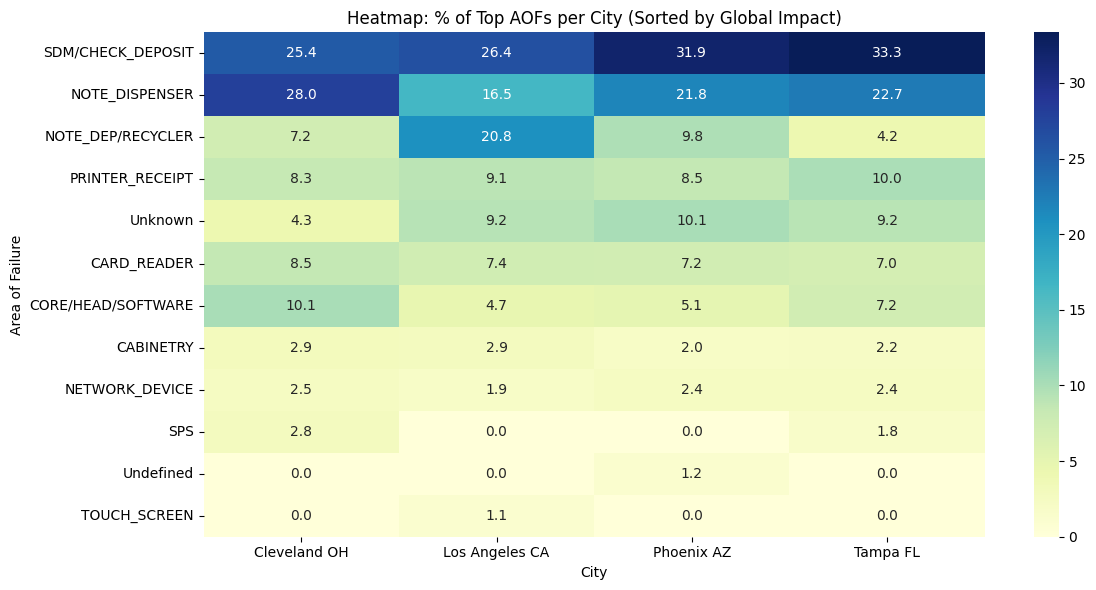

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot

# Fill missing or blank AOFs
sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].fillna('Unknown')
sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].replace('', 'Unknown')

# Step 1: Count per City + AOF
aof_city = (
    sr_data
    .groupby(['svc_area_desc', 'rptg_comb_aof_desc'])
    .size()
    .reset_index(name='count')
)

# Step 2: Get top 10 AOFs **per city** (by count)
aof_city['rank'] = aof_city.groupby('svc_area_desc')['count'].rank(method='first', ascending=False)
top10_aof_city = aof_city[aof_city['rank'] <= 10].copy()

# Step 3: Calculate % share within each city
city_totals = top10_aof_city.groupby('svc_area_desc')['count'].transform('sum')
top10_aof_city['percent'] = (top10_aof_city['count'] / city_totals * 100).round(2)


heatmap_data = top10_aof_city.pivot_table(
    index='rptg_comb_aof_desc',
    columns='svc_area_desc',
    values='percent'
).fillna(0)

# Sort rows (AOFs) by global total % descending
heatmap_data['Total'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values(by='Total', ascending=False)
heatmap_data.drop(columns='Total', inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Heatmap: % of Top AOFs per City (Sorted by Global Impact)")
plt.xlabel("City")
plt.ylabel("Area of Failure")
plt.tight_layout()
plt.show()


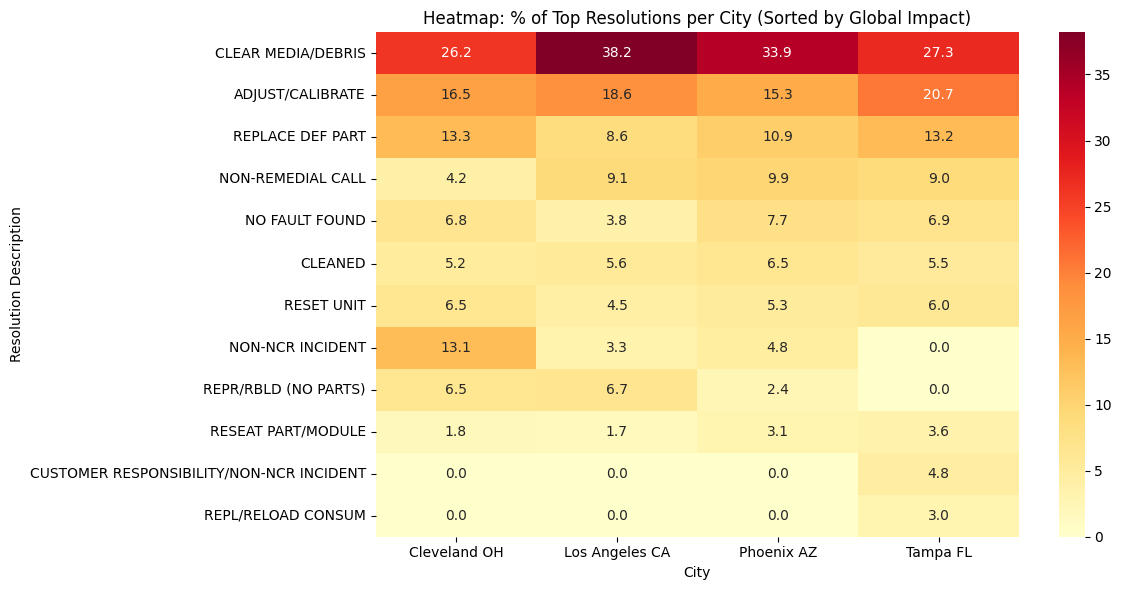

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean: Fill missing or blank Resolution values
sr_data['rptg_resolution_desc_1'] = sr_data['rptg_resolution_desc_1'].fillna('Unknown')
sr_data['rptg_resolution_desc_1'] = sr_data['rptg_resolution_desc_1'].replace('', 'Unknown')

# Step 1: Count per City + Resolution
res_city = (
    sr_data
    .groupby(['svc_area_desc', 'rptg_resolution_desc_1'])
    .size()
    .reset_index(name='count')
)

# Step 2: Get top 10 Resolutions per city
res_city['rank'] = res_city.groupby('svc_area_desc')['count'].rank(method='first', ascending=False)
top10_res_city = res_city[res_city['rank'] <= 10].copy()

# Step 3: Calculate % share within each city
city_totals = top10_res_city.groupby('svc_area_desc')['count'].transform('sum')
top10_res_city['percent'] = (top10_res_city['count'] / city_totals * 100).round(2)

# Step 4: Pivot table for heatmap
heatmap_res = top10_res_city.pivot_table(
    index='rptg_resolution_desc_1',
    columns='svc_area_desc',
    values='percent'
).fillna(0)

# Step 5: Sort rows by global total % descending
heatmap_res['Total'] = heatmap_res.sum(axis=1)
heatmap_res = heatmap_res.sort_values(by='Total', ascending=False)
heatmap_res.drop(columns='Total', inplace=True)

# Step 6: Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_res, annot=True, cmap="YlOrRd", fmt=".1f")
plt.title("Heatmap: % of Top Resolutions per City (Sorted by Global Impact)")
plt.xlabel("City")
plt.ylabel("Resolution Description")
plt.tight_layout()
plt.show()


In [159]:
import pandas as pd
import plotly.express as px

# Step 1: Clean the data
sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].fillna('Unknown').replace('', 'Unknown')
sr_data['rptg_resolution_desc_1'] = sr_data['rptg_resolution_desc_1'].fillna('Unknown').replace('', 'Unknown')

# Step 2: Get top 10 AOFs by count
top10_aofs_counts = sr_data['rptg_comb_aof_desc'].value_counts().head(10)
top10_aofs = top10_aofs_counts.index.tolist()

# Step 3: Filter for top AOFs
df_filtered = sr_data[sr_data['rptg_comb_aof_desc'].isin(top10_aofs)].copy()

# Step 4: Group and compute counts
grouped = (
    df_filtered.groupby(['rptg_comb_aof_desc', 'rptg_resolution_desc_1'])
    .size()
    .reset_index(name='count')
)

# Step 5: Normalize to percentage within each AOF
grouped['percent'] = grouped.groupby('rptg_comb_aof_desc')['count'].transform(lambda x: (x / x.sum()) * 100).round(2)


# Step 6: Pivot to wide format for heatmap
pivot_df = grouped.pivot(index='rptg_comb_aof_desc', columns='rptg_resolution_desc_1', values='percent').fillna(0)

# Optional: Sort rows based on original frequency order
pivot_df = pivot_df.loc[top10_aofs]

# Step 7: Plot heatmap using Plotly
fig = px.imshow(
    pivot_df,
    text_auto=".1f",
    aspect="auto",
    labels=dict(x="Resolution Description", y="Area of Failure", color="Percent"),
    color_continuous_scale="YlOrRd"
)

fig.update_layout(
    title="Heatmap: Resolution Distribution (%) for Top 10 AOFs",
    xaxis_title="Resolution",
    yaxis_title="AOF",
    height=600
)

fig.show()


In [160]:
import pandas as pd

# Step 1: Clean columns
sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].fillna('Unknown').replace('', 'Unknown')
sr_data['rptg_resolution_desc_1'] = sr_data['rptg_resolution_desc_1'].fillna('Unknown').replace('', 'Unknown')

# Step 2: Get top 10 AOFs by count
aof_counts = sr_data['rptg_comb_aof_desc'].value_counts()
top10_aofs = aof_counts.head(10).index.tolist()

# Step 3: Filter data to top AOFs
df_filtered = sr_data[sr_data['rptg_comb_aof_desc'].isin(top10_aofs)].copy()

# Step 4: Group by AOF + Resolution and calculate count
grouped = (
    df_filtered.groupby(['rptg_comb_aof_desc', 'rptg_resolution_desc_1'])
    .size()
    .reset_index(name='count')
)

# Step 5: Calculate % within each AOF
grouped['percent'] = grouped.groupby('rptg_comb_aof_desc')['count'].transform(lambda x: (x / x.sum()) * 100).round(2)

# Step 6: Get top 5 resolutions per AOF
grouped_top5 = (
    grouped
    .sort_values(['rptg_comb_aof_desc', 'count'], ascending=[True, False])
    .groupby('rptg_comb_aof_desc')
    .head(5)
)

# Step 7: Add total AOF count as a column for sorting
grouped_top5['aof_total_count'] = grouped_top5['rptg_comb_aof_desc'].map(aof_counts)

# Step 8: Sort final DataFrame
final_df = grouped_top5.sort_values(by=['aof_total_count', 'count'], ascending=[False, False])

# Step 9: Reset index for display
final_df = final_df.reset_index(drop=True)
final_df


,rptg_comb_aof_desc,rptg_resolution_desc_1,count,percent,aof_total_count
0,SDM/CHECK_DEPOSIT,CLEAR MEDIA/DEBRIS,15829,47.65,33221
1,SDM/CHECK_DEPOSIT,REPLACE DEF PART,4977,14.98,33221
2,SDM/CHECK_DEPOSIT,ADJUST/CALIBRATE,4480,13.49,33221
3,SDM/CHECK_DEPOSIT,CLEANED,2430,7.31,33221
4,SDM/CHECK_DEPOSIT,REPR/RBLD (NO PARTS),1384,4.17,33221
5,NOTE_DISPENSER,CLEAR MEDIA/DEBRIS,7200,30.82,23360
6,NOTE_DISPENSER,ADJUST/CALIBRATE,6228,26.66,23360
7,NOTE_DISPENSER,REPLACE DEF PART,2631,11.26,23360
8,NOTE_DISPENSER,NO FAULT FOUND,1382,5.92,23360
9,NOTE_DISPENSER,RESEAT PART/MODULE,1354,5.80,23360


# Features

In [161]:
sr_data.columns

Index(['sr_nbr', 'svc_country_code', 'creation_dt_ltz', 'closed_on_dt_ltz',
       'invtry_item_desc', 'problem_summary_text', 'resolution_summary_text',
       'svc_attribute_13', 'fld_parts_used_qty', 'fld_trvl_to_elps_mnt_cnt',
       'fld_trvl_fr_elps_min_cnt', 'rptg_area_of_failure_code_1',
       'rptg_comb_aof_desc', 'rptg_resolution_code_1',
       'rptg_resolution_desc_1', 'svc_area_desc', 'rptg_sr_severity_code',
       'rptg_sr_type_code', 'rptg_sr_status_code', 'class_code',
       'fld_parts_used_ind', 'best_fit_offer_id_hyphen',
       'final_item_serial_nbr', 'rsrc_branch_code', 'rsrc_territory_code',
       'end_clndr_wk_edate_ltz', 'customer_name', 'fld_onsite_cnt',
       'end_acctg_mth_edate_ltz', 'orig_severity_name',
       'sn_7d_opportunity_ind', 'sn_7d_rsltn_failure_ind', 'Travel Hours',
       'Repair Hours', 'Total hours', 'Close Date', 'closed_month', 'location',
       'voltage', 'sub_model', 'reoccurrence_days', 'month'],
      dtype='object')

In [162]:
# !!pip install --upgrade jupyter-dash


In [163]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, Input, Output, dash_table
import threading
import webbrowser
import time

# ---------- Prepare Your Data ----------
sr_data['creation_dt_ltz'] = pd.to_datetime(sr_data['creation_dt_ltz'], errors='coerce')
sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].fillna('Unknown').replace('', 'Unknown')
sr_data['rptg_resolution_desc_1'] = sr_data['rptg_resolution_desc_1'].fillna('Unknown').replace('', 'Unknown')
sr_data['svc_area_desc'] = sr_data['svc_area_desc'].fillna('Unknown')

available_cities = sorted(sr_data['svc_area_desc'].unique())

# ---------- Start App ----------
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# ---------- Layout ----------
app.layout = dbc.Container([
    html.H2("📊 Reoccurrence Gap Analysis Dashboard", className="my-3"),

    dbc.Row([
        dbc.Col([
            html.Label("Select Cities:"),
            dcc.Dropdown(
                id="city_selector",
                options=[{"label": c, "value": c} for c in available_cities],
                value=available_cities[:2],
                multi=True
            )
        ], md=4),

        dbc.Col([
            html.Label("Category Type:"),
            dcc.RadioItems(
                id="category_type",
                options=[
                    {"label": "AOF", "value": "rptg_comb_aof_desc"},
                    {"label": "Resolution", "value": "rptg_resolution_desc_1"}
                ],
                value="rptg_comb_aof_desc",
                inline=True
            )
        ], md=4),

        dbc.Col([
            html.Label("Top N Categories:"),
            dcc.Dropdown(
                id="top_n_selector",
                options=[{"label": f"Top {i}", "value": i} for i in [5, 10, 15, 20, 100]],
                value=10,
                clearable=False
            )
        ], md=4),
    ], className="mb-4"),

    dbc.Tabs([
        dbc.Tab(label="📌 AOF Distribution", tab_id="aof"),
        dbc.Tab(label="📌 Resolution Distribution", tab_id="resolution"),
        dbc.Tab(label="📍 Location Comparison", tab_id="location_compare"),
    ], id="main_tabs", active_tab="aof"),

    html.Br(),
    dcc.Graph(id="box_plot"),
    html.Br(),
    html.H5("📋 Summary Table"),
    dash_table.DataTable(
        id="summary_table",
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center'},
        page_size=10
    )
], fluid=True)


@app.callback(
    Output("box_plot", "figure"),
    Output("summary_table", "data"),
    Output("summary_table", "columns"),
    Input("main_tabs", "active_tab"),
    Input("city_selector", "value"),
    Input("category_type", "value"),
    Input("top_n_selector", "value")
)
def update_dashboard(tab, selected_cities, category_field, top_n):
    if not selected_cities:
        return go.Figure(), [], []

    df = sr_data[sr_data['svc_area_desc'].isin(selected_cities)].copy()
    df[category_field] = df[category_field].fillna("Unknown").replace("", "Unknown")

    # Get Top-N categories
    top_categories = df[category_field].value_counts().head(top_n).index
    df_top = df[df[category_field].isin(top_categories)].copy()

    # Sort and compute gap
    df_top = df_top.sort_values(by=['final_item_serial_nbr', category_field, 'creation_dt_ltz'])
    df_top['days_gap'] = (
        df_top
        .groupby(['final_item_serial_nbr', category_field])['creation_dt_ltz']
        .diff()
        .dt.days
    )
    df_top = df_top[df_top['days_gap'].notna()]
    df_top[category_field] = pd.Categorical(df_top[category_field], categories=top_categories, ordered=True)

    # Summary stats
    summary = df_top.groupby("svc_area_desc")['days_gap'].agg(
        ['count', 'mean', 'median', 'max']).reset_index()
    summary.columns = [col.capitalize() for col in summary.columns]
    summary_data = summary.to_dict("records")
    summary_columns = [{"name": i, "id": i} for i in summary.columns]

    # ---------- Graph Logic ----------
    if tab in ["aof", "resolution"]:
        fig = px.box(
            df_top,
            x='days_gap',
            y=category_field,
            color=category_field,
            category_orders={category_field: top_categories},
            points=False
        )
        medians = df_top.groupby(category_field)['days_gap'].median()
        for cat in top_categories:
            fig.add_trace(go.Scatter(
                x=[medians[cat]],
                y=[cat],
                mode='text',
                text=[f"{medians[cat]:.1f}"],
                textposition='middle right',
                showlegend=False
            ))
        fig.update_layout(
            title=f"{'AOF' if category_field=='rptg_comb_aof_desc' else 'Resolution'} Distribution",
            xaxis_title="Days Between Reoccurrences",
            yaxis_title="Category",
            height=600,
            template='plotly_white'
        )
    else:  # location_compare
        fig = px.box(
            df_top,
            x="svc_area_desc",
            y="days_gap",
            color="svc_area_desc",
            facet_col=category_field,
            facet_col_wrap=2,
            points=False,
            category_orders={category_field: top_categories}
        )
        fig.update_layout(
            title=f"📍 Location-wise Reoccurrence Comparison by {'AOF' if category_field=='rptg_comb_aof_desc' else 'Resolution'}",
            xaxis_title="City",
            yaxis_title="Days Between Reoccurrences",
            height=900,
            template='plotly_white'
        )

    return fig, summary_data, summary_columns



def open_chrome():
    time.sleep(1)
    webbrowser.get("chrome").open("http://127.0.0.1:8060")

threading.Thread(target=open_chrome).start()
app.run(debug=False, use_reloader=False, port=8060)


/var/folders/k0/spmhqxb9567f9tycx8kp0s140000gn/T/ipykernel_41163/1877596418.py:128: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/k0/spmhqxb9567f9tycx8kp0s140000gn/T/ipykernel_41163/1877596418.py:128: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [164]:
from dash import Dash, dcc, html, Input, Output, dash_table
import dash_bootstrap_components as dbc
import pandas as pd
import plotly.express as px
import threading, webbrowser, time
import datetime

# Convert to datetime
sr_data['creation_dt_ltz'] = pd.to_datetime(sr_data['creation_dt_ltz'], errors='coerce')
sr_data['closed_on_dt_ltz'] = pd.to_datetime(sr_data['closed_on_dt_ltz'], errors='coerce')

# Fill missing
sr_data['rptg_comb_aof_desc'] = sr_data['rptg_comb_aof_desc'].fillna('Unknown').replace('', 'Unknown')
sr_data['svc_area_desc'] = sr_data['svc_area_desc'].fillna('Unknown')
sr_data['Repair Hours'] = pd.to_numeric(sr_data['Repair Hours'], errors='coerce')
sr_data['fld_parts_used_qty'] = pd.to_numeric(sr_data['fld_parts_used_qty'], errors='coerce')

top_devices = sr_data['final_item_serial_nbr'].value_counts().head(20).index

# App
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    html.H2("🛠️ Device-Level Dashboard", className="my-3"),

    dcc.Dropdown(
        id='device-dropdown',
        options=[{'label': d, 'value': d} for d in top_devices],
        value=top_devices[0],
        placeholder='Select a device',
        className="mb-4"
    ),

    dbc.Row([
        dbc.Col(html.Div(id='device-summary'), width=4),
        dbc.Col(dcc.Graph(id='issue-trend'), width=8),
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id='aof-bar'), width=6),
        dbc.Col(dcc.Graph(id='resolution-bar'), width=6),
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id='repair-box'), width=12),
    ])
], fluid=True)


@app.callback(
    Output('device-summary', 'children'),
    Output('issue-trend', 'figure'),
    Output('aof-bar', 'figure'),
    Output('resolution-bar', 'figure'),
    Output('repair-box', 'figure'),
    Input('device-dropdown', 'value')
)
def update_dashboard(device):
    df = sr_data[sr_data['final_item_serial_nbr'] == device].copy()
    today = pd.to_datetime("2025-07-01")

    # Summary metrics
    total_issues = len(df)
    unique_aofs = df['rptg_comb_aof_desc'].nunique()
    median_gap = df.sort_values('creation_dt_ltz').groupby('rptg_comb_aof_desc')['creation_dt_ltz'].diff().dt.days.median()
    median_gap = 0 if pd.isna(median_gap) else int(median_gap)

    total_revisit_7 = (df.groupby('rptg_comb_aof_desc')['creation_dt_ltz'].diff().dt.days <= 7).sum()
    total_revisit_15 = (df.groupby('rptg_comb_aof_desc')['creation_dt_ltz'].diff().dt.days <= 15).sum()
    total_revisit_30 = (df.groupby('rptg_comb_aof_desc')['creation_dt_ltz'].diff().dt.days <= 30).sum()

    last_call_days = (today - df['closed_on_dt_ltz'].max()).days if df['closed_on_dt_ltz'].notna().any() else None

    summary = {
        'Device': device,
        'City': df['svc_area_desc'].iloc[0],
        'Customer': df['customer_name'].iloc[0],
        'Branch Code': df['rsrc_branch_code'].iloc[0],
        'Class Code': df['class_code'].iloc[0],
        'Total Issues': total_issues,
        'Unique AOFs': unique_aofs,
        'Median Days Between Issues': median_gap,
        'Total Revisits (<=7d)': int(total_revisit_7),
        'Total Revisits (<=15d)': int(total_revisit_15),
        'Total Revisits (<=30d)': int(total_revisit_30),
        'Sum Parts Used': round(df['fld_parts_used_qty'].sum(), 2),
        'Max Parts Used': int(df['fld_parts_used_qty'].max()),
        'Median Repair Hours': round(df['Repair Hours'].median(), 2),
        'Days Since Last Service Call': int(last_call_days)
    }

    summary_df = pd.DataFrame(summary.items(), columns=["Metric", "Value"])
    summary_table = dash_table.DataTable(

    style_data_conditional=[
        {
            'if': {'column_id': 'Metric'},
            'backgroundColor': '#e6f7ff',
            'color': 'black',
            'fontWeight': 'bold'
        },
        {
            'if': {'column_id': 'Value'},
            'backgroundColor': '#ffffff',
            'color': 'black'
        }],
        data=summary_df.to_dict('records'),
        columns=[{"name": i, "id": i} for i in summary_df.columns],
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'fontWeight': 'bold', 'backgroundColor': '#f2f2f2'},
        style_table={'overflowX': 'auto'},
    )

    # Trend chart
    df['month'] = df['creation_dt_ltz'].dt.to_period("M").astype(str)
    issue_trend = df.groupby('month').size().reset_index(name='count')
    fig_trend = px.line(issue_trend, x='month', y='count', markers=True, title="Issue Frequency Over Time")
    fig_trend.update_traces(line=dict(color='royalblue'))

    # AOF chart
    aof_count = df['rptg_comb_aof_desc'].value_counts().reset_index()
    aof_count.columns = ['AOF', 'Count']
    fig_aof = px.bar(aof_count.sort_values('Count', ascending=False).head(10),
                     x='Count', y='AOF', title="Top AOF Types", orientation='h', color="AOF")

    # Resolution chart
    df['rptg_resolution_desc_1'] = df['rptg_resolution_desc_1'].fillna('Unknown')
    resolution_count = df['rptg_resolution_desc_1'].value_counts().reset_index()
    resolution_count.columns = ['Resolution', 'Count']
    fig_resolution = px.bar(resolution_count.head(10),
                            x='Count', y='Resolution', title="Top Resolution Types", orientation='h',
                            color="Resolution", color_continuous_scale='Cividis')

    # Box plot
    fig_box = px.box(df[df['Repair Hours'].notna()], y='Repair Hours', title="Repair Hours Distribution", points='all',
                     color_discrete_sequence=["#5030D2"])

    return summary_table, fig_trend, fig_aof, fig_resolution, fig_box


def open_chrome():
    time.sleep(1)
    webbrowser.get("chrome").open("http://127.0.0.1:8050")


threading.Thread(target=open_chrome).start()
app.run(debug=False, use_reloader=False, port=8050)


In [165]:
sr_data['final_item_serial_nbr'].value_counts().head(20)

final_item_serial_nbr
71-60724684    210
30-48826688    206
30-48826780    196
30-48826489    195
13-52565208    192
30-48826712    190
57-58243020    173
71-60724667    173
71-60724611    172
71-60723809    167
30-48826665    166
13-57426961    165
71-60724677    164
13-57427110    161
30-48826718    153
30-48827091    153
57-58228320    150
30-48827053    149
30-48826654    148
13-57427027    147
Name: count, dtype: int64

In [166]:
sr_data.columns

Index(['sr_nbr', 'svc_country_code', 'creation_dt_ltz', 'closed_on_dt_ltz',
       'invtry_item_desc', 'problem_summary_text', 'resolution_summary_text',
       'svc_attribute_13', 'fld_parts_used_qty', 'fld_trvl_to_elps_mnt_cnt',
       'fld_trvl_fr_elps_min_cnt', 'rptg_area_of_failure_code_1',
       'rptg_comb_aof_desc', 'rptg_resolution_code_1',
       'rptg_resolution_desc_1', 'svc_area_desc', 'rptg_sr_severity_code',
       'rptg_sr_type_code', 'rptg_sr_status_code', 'class_code',
       'fld_parts_used_ind', 'best_fit_offer_id_hyphen',
       'final_item_serial_nbr', 'rsrc_branch_code', 'rsrc_territory_code',
       'end_clndr_wk_edate_ltz', 'customer_name', 'fld_onsite_cnt',
       'end_acctg_mth_edate_ltz', 'orig_severity_name',
       'sn_7d_opportunity_ind', 'sn_7d_rsltn_failure_ind', 'Travel Hours',
       'Repair Hours', 'Total hours', 'Close Date', 'closed_month', 'location',
       'voltage', 'sub_model', 'reoccurrence_days', 'month'],
      dtype='object')

In [167]:
def extract_fields(offer_id):
    try:
        offer_id = str(offer_id)  # Ensure it's string
        parts = offer_id.split('-')
        if len(parts) != 3:
            return (None, None, None)

        placement_digit = parts[1][0]
        voltage_digit = parts[2][0]
        sub_model_code = parts[1][2:4]

        # Location mapping
        location_map = {
            '2': '2 Lobby',
            '3': '3 Vestibule',
            '4': '4 TTW WU',
            '5': '5 TTW DU',
            '6': '6 Deposit Lobby/TTW',
            '7': '7 Deposit Vestibule',
            '8': '8 Freestanding'
        }

        # Voltage mapping
        voltage_map = {
            '6': '6 120v',
            '8': '8 240v'
        }

        location = location_map.get(placement_digit, 'Unknown')
        voltage = voltage_map.get(voltage_digit, 'Unknown')

        return (location, voltage, sub_model_code)
    
    except Exception:
        return (None, None, None)

# Apply the function and expand results into columns
sr_data[['location', 'voltage', 'sub_model']] = sr_data['best_fit_offer_id_hyphen'].apply(extract_fields).apply(pd.Series)


In [168]:
sr_data['sub_model'].value_counts()

sub_model
00    89794
50     8202
03     5004
07     2590
11     2069
      ...  
33        1
38        1
13        1
74        1
39        1
Name: count, Length: 69, dtype: int64

In [169]:
sr_data['location'].value_counts()

location
4 TTW WU               36651
2 Lobby                30150
8 Freestanding         24935
Unknown                12011
3 Vestibule            11647
5 TTW DU                8387
7 Deposit Vestibule     1220
6 Deposit Lobby/TTW        1
Name: count, dtype: int64

In [170]:
sr_data[['best_fit_offer_id_hyphen', 'location', 'voltage', 'sub_model']].head(100)

,best_fit_offer_id_hyphen,location,voltage,sub_model
86844,7530-0545-9801,Unknown,Unknown,45
56632,7530-0545-9801,Unknown,Unknown,45
39241,7530-0545-9801,Unknown,Unknown,45
72576,7305-0111-9801,Unknown,Unknown,11
94909,7530-0655-9801,Unknown,Unknown,55
...,...,...,...,...
74883,6622-2000-6000,2 Lobby,6 120v,00
80830,6622-2000-6000,2 Lobby,6 120v,00
73620,6622-2000-6000,2 Lobby,6 120v,00
86385,6622-2000-6000,2 Lobby,6 120v,00


In [171]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc

def plot_faceted_boxplot_with_overall(sr_data, aof_field, group_fields, date_field='creation_dt_ltz'):
    sr_data[aof_field] = sr_data[aof_field].fillna("Unknown").replace("", "Unknown")
    
    app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

    app.layout = dbc.Container([
        html.H3("Reoccurrence Days - Faceted and Overall Box Plot Viewer"),
        html.Label("Select Group Field"),
        dcc.Dropdown(
            id='group-field-dropdown',
            options=[{'label': col, 'value': col} for col in group_fields],
            value=group_fields[0],
            clearable=False
        ),
        dcc.Graph(id='faceted-boxplot'),
        html.Hr(),
        html.H4("Overall AOF Box Plot"),
        dcc.Graph(id='overall-boxplot')
    ], fluid=True)

    @app.callback(
        Output('faceted-boxplot', 'figure'),
        Output('overall-boxplot', 'figure'),
        Input('group-field-dropdown', 'value')
    )
    def update_plots(group_field):
        top_aofs = sr_data[aof_field].value_counts().index.tolist()
        top_aofs = [aof for aof in top_aofs if aof != "Unknown"][:6]
        df = sr_data[sr_data[aof_field].isin(top_aofs)].copy()
        df = df.sort_values(by=['final_item_serial_nbr', aof_field, date_field])
        df['reoccurrence_days'] = (
            df.groupby(['final_item_serial_nbr', aof_field])[date_field]
            .diff().dt.days
        )
        df = df[df['reoccurrence_days'].notna() & (df['reoccurrence_days'] > 0)]
        df[group_field] = df[group_field].fillna("Unknown").astype(str)
        df = df[df[aof_field] != "Unknown"]
        top_groups = df[group_field].value_counts().head(5).index
        df = df[df[group_field].isin(top_groups)]

        fig_facet = px.box(
            df,
            x=group_field,
            y='reoccurrence_days',
            color=group_field,
            facet_col=aof_field,
            facet_col_wrap=3,
            title=f"Reoccurrence Days by {group_field} Faceted by AOF",
            labels={'reoccurrence_days': 'Days Between Reoccurrences'},
            points=False,
        )
        fig_facet.update_layout(height=650)

        fig_overall = px.box(
            df,
            x=group_field,
            y='reoccurrence_days',
            color=group_field,
            title=f"Overall Reoccurrence Days by {group_field} (All AOFs Combined)",
            labels={'reoccurrence_days': 'Days Between Reoccurrences'},
            points=False,
        )
        fig_overall.update_layout(height=500)

        return fig_facet, fig_overall

    return app

# Assuming you have your sr_data DataFrame ready
chrome_path = 'open -a /Applications/Google\ Chrome.app %s'
webbrowser.get(chrome_path).open('http://127.0.0.1:8050/')


group_fields = ['class_code', 'svc_area_desc', 'svc_attribute_13', 'rptg_sr_type_code', 'fld_onsite_cnt', 'sn_7d_opportunity_ind', 'location', 'voltage', 'sub_model']
app = plot_faceted_boxplot_with_overall(sr_data, 'rptg_comb_aof_desc', group_fields)
app.run(mode='external')  # for Jupyter Notebook; use mode='external' to open in a browser



In [127]:
import pandas as pd

def compute_reoccurrence_summary(sr_data, aof_field, group_fields, date_field='creation_dt_ltz'):
    sr_data[aof_field] = sr_data[aof_field].fillna("Unknown").replace("", "Unknown")
    
    # Top 6 AOFs excluding Unknown
    top_aofs = sr_data[aof_field].value_counts().drop("Unknown", errors='ignore').head(6).index.tolist()

    # Compute reoccurrence_days
    sr_data_sorted = sr_data.sort_values(by=['final_item_serial_nbr', aof_field, date_field])
    sr_data_sorted['reoccurrence_days'] = sr_data_sorted.groupby(['final_item_serial_nbr', aof_field])[date_field].diff().dt.days
    sr_data_sorted = sr_data_sorted[sr_data_sorted['reoccurrence_days'].notna()].copy()

    result = []

    for field in group_fields:
        sr_data_sorted[field] = sr_data_sorted[field].fillna("Unknown").astype(str)
        top_values = sr_data_sorted[field].value_counts().head(5).index.tolist()

        for val in top_values:
            row = {'Field': field, 'Value': val}
            df_group = sr_data_sorted[sr_data_sorted[field] == val]
            row['All_AOFs'] = df_group['reoccurrence_days'].median()

            for aof in top_aofs:
                df_filtered = df_group[df_group[aof_field] == aof]
                row[aof] = df_filtered['reoccurrence_days'].median()

            result.append(row)

    df_summary = pd.DataFrame(result)
    return df_summary


group_fields = ['class_code', 'svc_area_desc', 'svc_attribute_13', 'rptg_sr_type_code', 'fld_onsite_cnt', 'sn_7d_opportunity_ind', 'location', 'voltage', 'sub_model']
summary_df = compute_reoccurrence_summary(sr_data, aof_field='rptg_comb_aof_desc', group_fields=group_fields)


In [128]:
summary_df.to_clipboard()

In [103]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output, dash_table
import numpy as np

# ---------- Summary Function ----------
def compute_summary_tables(sr_data, group_fields, aof_field='rptg_comb_aof_desc', date_field='creation_dt_ltz'):
    sr_data[aof_field] = sr_data[aof_field].fillna("Unknown").replace("", "Unknown")
    top_aofs = sr_data[aof_field].value_counts().drop("Unknown", errors='ignore').head(6).index.tolist()

    sr_data = sr_data.sort_values(by=['final_item_serial_nbr', aof_field, date_field])
    sr_data['reoccurrence_days'] = sr_data.groupby(['final_item_serial_nbr', aof_field])[date_field].diff().dt.days
    sr_data = sr_data[sr_data['reoccurrence_days'].notna()].copy()

    median_tables = {}
    count_tables = {}
    value_frequencies = {}

    for field in group_fields:
        sr_data[field] = sr_data[field].fillna("Unknown").astype(str)
        value_frequencies[field] = sr_data[field].value_counts()

        median_df = sr_data.groupby(field)['reoccurrence_days'].median().rename('All_AOFs').reset_index()
        for aof in top_aofs:
            temp = sr_data[sr_data[aof_field] == aof].groupby(field)['reoccurrence_days'].median().rename(aof).reset_index()
            median_df = pd.merge(median_df, temp, on=field, how='left')
        median_tables[field] = median_df

        count_df = sr_data.groupby(field)['reoccurrence_days'].count().rename('All_AOFs').reset_index()
        for aof in top_aofs:
            temp = sr_data[sr_data[aof_field] == aof].groupby(field)['reoccurrence_days'].count().rename(aof).reset_index()
            count_df = pd.merge(count_df, temp, on=field, how='left')
        count_tables[field] = count_df

    return median_tables, count_tables, group_fields, value_frequencies

# ---------- Heatmap-style formatting ----------
def get_heatmap_style(df):
    styles = []
    # numeric_cols = df.select_dtypes(include=[np.number]).columns

    # max_val = df[numeric_cols].max().max()
    # min_val = df[numeric_cols].min().min()

    # for col in numeric_cols:
    #     for i in range(len(df)):
    #         val = df.iloc[i][col]
    #         if pd.notna(val):
    #             norm = (val - min_val) / (max_val - min_val + 1e-6)
    #             hue = 120 * norm  # Red (0) → Green (120) as value increases
    #             color = f'hsl({hue}, 50%, 75%)'  # Softer saturation/lightness
    #             text_color = 'black' if norm < 0.7 else 'white'
    #             styles.append({
    #                 'if': {'filter_query': f'{{{col}}} = {val}', 'column_id': col},
    #                 'backgroundColor': color,
    #                 'color': text_color
    #             })
    return styles





# ---------- Dash App ----------
def build_dash_app(sr_data):
    group_fields = ['class_code', 'svc_area_desc', 'svc_attribute_13', 'rptg_sr_type_code',
                    'fld_onsite_cnt', 'sn_7d_opportunity_ind', 'location', 'voltage', 'sub_model']

    median_tables, count_tables, group_fields, value_frequencies = compute_summary_tables(sr_data, group_fields)

    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.H3("🔁 Reoccurrence Summary Tables"),

        html.Div([
            html.Label("Select Group Field:"),
            dcc.Dropdown(id='group-dropdown', options=[{'label': f, 'value': f} for f in group_fields],
                         value=group_fields[0])
        ], style={'width': '40%', 'display': 'inline-block'}),

        html.Div([
            html.Label("Top N Values to Display:"),
            dcc.Input(id='top-n', type='number', min=1, max=20, step=1, value=10)
        ], style={'width': '20%', 'display': 'inline-block', 'marginLeft': '20px'}),

        html.H4("📊 Median Table (Days Between Issues)"),
        html.Div(id='median-table'),

        html.H4("📈 Count Table (Reoccurrence Events)"),
        html.Div(id='count-table'),
    ])

    @app.callback(
        Output('median-table', 'children'),
        Output('count-table', 'children'),
        Input('group-dropdown', 'value'),
        Input('top-n', 'value')
    )
    def update_tables(group_field, top_n):
        # Get top N group values by frequency
        freq_series = value_frequencies[group_field]
        top_vals = freq_series.head(top_n).index.tolist()

        # Reorder both DataFrames based on the same order of top_vals
        median_df = median_tables[group_field].copy()
        count_df = count_tables[group_field].copy()

        median_df = median_df.set_index(group_field).loc[top_vals].reset_index()
        count_df = count_df.set_index(group_field).loc[top_vals].reset_index()

        style_median = get_heatmap_style(median_df)
        style_count = get_heatmap_style(count_df)

        median_table = dash_table.DataTable(
            columns=[{"name": i, "id": i} for i in median_df.columns],
            data=median_df.to_dict('records'),
            style_data_conditional=style_median,
            style_table={'overflowX': 'auto'},
            page_size=20,
        )

        count_table = dash_table.DataTable(
            columns=[{"name": i, "id": i} for i in count_df.columns],
            data=count_df.to_dict('records'),
            style_data_conditional=style_count,
            style_table={'overflowX': 'auto'},
            page_size=20,
        )

        return median_table, count_table


    return app




# Assuming you have your sr_data DataFrame ready
chrome_path = 'open -a /Applications/Google\ Chrome.app %s'
webbrowser.get(chrome_path).open('http://127.0.0.1:8050/')


group_fields = ['class_code', 'svc_area_desc', 'svc_attribute_13', 'rptg_sr_type_code', 'fld_onsite_cnt', 'sn_7d_opportunity_ind', 'location', 'voltage', 'sub_model']
app = build_dash_app(sr_data)
app.run(mode='external')  # for Jupyter Notebook; use mode='external' to open in a browser


In [104]:
sr_data.columns

Index(['sr_nbr', 'svc_country_code', 'creation_dt_ltz', 'closed_on_dt_ltz',
       'invtry_item_desc', 'problem_summary_text', 'resolution_summary_text',
       'svc_attribute_13', 'fld_parts_used_qty', 'fld_trvl_to_elps_mnt_cnt',
       'fld_trvl_fr_elps_min_cnt', 'rptg_area_of_failure_code_1',
       'rptg_comb_aof_desc', 'rptg_resolution_code_1',
       'rptg_resolution_desc_1', 'svc_area_desc', 'rptg_sr_severity_code',
       'rptg_sr_type_code', 'rptg_sr_status_code', 'class_code',
       'fld_parts_used_ind', 'best_fit_offer_id_hyphen',
       'final_item_serial_nbr', 'rsrc_branch_code', 'rsrc_territory_code',
       'end_clndr_wk_edate_ltz', 'customer_name', 'fld_onsite_cnt',
       'end_acctg_mth_edate_ltz', 'orig_severity_name',
       'sn_7d_opportunity_ind', 'sn_7d_rsltn_failure_ind', 'Travel Hours',
       'Repair Hours', 'Total hours', 'Close Date', 'closed_month', 'location',
       'voltage', 'sub_model', 'reoccurrence_days'],
      dtype='object')

In [130]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html

# Load your actual `sr_data` DataFrame here
# sr_data = pd.read_csv('your_sr_data.csv')  # Replace with your data source

def compute_month_level_boxplots(sr_data, aof_field='rptg_comb_aof_desc', date_field='closed_on_dt_ltz'):
    sr_data[aof_field] = sr_data[aof_field].fillna("Unknown").replace("", "Unknown")
    sr_data[date_field] = pd.to_datetime(sr_data[date_field])

    sr_data['month'] = sr_data[date_field].dt.to_period('M').astype(str)

    sr_data = sr_data.sort_values(by=['final_item_serial_nbr', aof_field, date_field])
    sr_data['reoccurrence_days'] = sr_data.groupby(['final_item_serial_nbr', aof_field])[date_field].diff().dt.days
    sr_data = sr_data[sr_data['reoccurrence_days'].notna()].copy()

    top_aofs = sr_data[aof_field].value_counts().drop("Unknown", errors='ignore').head(6).index.tolist()

    plots = []

    fig_all = px.box(sr_data, x='month', y='reoccurrence_days', points='all',
                     title="All AOFs - Reoccurrence Days by Month")
    plots.append(dcc.Graph(figure=fig_all))

    for aof in top_aofs:
        df = sr_data[sr_data[aof_field] == aof]
        fig = px.box(df, x='month', y='reoccurrence_days', points='all',
                     title=f"{aof} - Reoccurrence Days by Month")
        plots.append(dcc.Graph(figure=fig))

    return plots

def build_app(sr_data):
    app = dash.Dash(__name__)
    plots = compute_month_level_boxplots(sr_data)

    app.layout = html.Div([
        html.H2("📅 Monthly Reoccurrence Analysis"),
        html.Div(plots)
    ])
    return app



# Assuming you have your sr_data DataFrame ready
chrome_path = 'open -a /Applications/Google\ Chrome.app %s'
webbrowser.get(chrome_path).open('http://127.0.0.1:8050/')


group_fields = ['class_code', 'svc_area_desc', 'svc_attribute_13', 'rptg_sr_type_code', 'fld_onsite_cnt', 'sn_7d_opportunity_ind', 'location', 'voltage', 'sub_model']
app = build_app(sr_data)
app.run(mode='external') 


In [118]:
sr_data['closed_on_dt_ltz'] = pd.to_datetime(sr_data['closed_on_dt_ltz'])
sr_data['month'] = sr_data['closed_on_dt_ltz'].dt.to_period('M').astype(str)
sr_data['month'].value_counts().sort_index()

month
2024-06    10502
2024-07    10845
2024-08    10664
2024-09     9580
2024-10    10055
2024-11     9314
2024-12     9499
2025-01    10208
2025-02     8675
2025-03     9018
2025-04     8724
2025-05     9149
2025-06     8769
Name: count, dtype: int64

<Axes: title={'center': 'Avg Reoccurrence Days by Month'}, xlabel='month'>

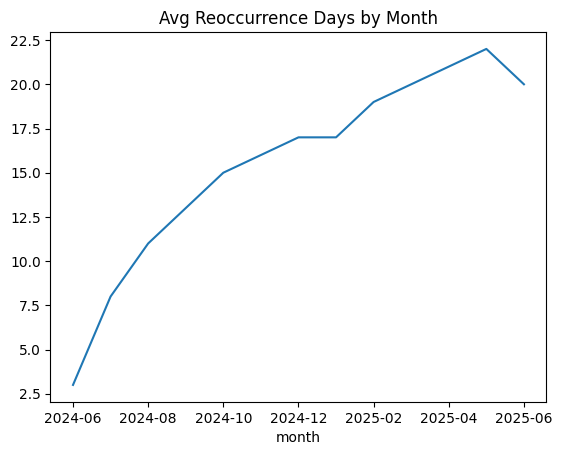

In [131]:
sr_data.groupby('month')['reoccurrence_days'].median().plot(kind='line', title='Avg Reoccurrence Days by Month')


In [ ]:
sr_data['final_item_serial_nbr'].value_counts()

final_item_serial_nbr
71-60724684    210
30-48826688    206
30-48826780    196
30-48826489    195
13-52565208    192
              ... 
94-58371439      1
94-58371491      1
94-58371492      1
94-58371503      1
YT52400006       1
Name: count, Length: 6912, dtype: int64

In [117]:
sr_data[(sr_data['reoccurrence_days'].notna()) & (sr_data['final_item_serial_nbr']=='71-60724684')][['month','rptg_comb_aof_desc', 'reoccurrence_days']].sort_values('month')

,month,rptg_comb_aof_desc,reoccurrence_days
83302,2024-06,NOTE_DEP/RECYCLER,2.0
99762,2024-06,NOTE_DEP/RECYCLER,1.0
78687,2024-06,NOTE_DEP/RECYCLER,1.0
117311,2024-06,NOTE_DEP/RECYCLER,13.0
34988,2024-06,NOTE_DEP/RECYCLER,0.0
...,...,...,...
74109,2025-06,NOTE_DEP/RECYCLER,3.0
72528,2025-06,NOTE_DEP/RECYCLER,1.0
71226,2025-06,NOTE_DEP/RECYCLER,0.0
106003,2025-06,NOTE_DEP/RECYCLER,1.0


In [123]:
sr_data['final_item_serial_nbr'].value_counts()

final_item_serial_nbr
71-60724684    210
30-48826688    206
30-48826780    196
30-48826489    195
13-52565208    192
              ... 
94-58371439      1
94-58371491      1
94-58371492      1
94-58371503      1
YT52400006       1
Name: count, Length: 6912, dtype: int64

In [125]:
import pandas as pd
import plotly.express as px

# Step 1: Count number of issues per device
device_issue_counts = sr_data['final_item_serial_nbr'].value_counts()
device_issue_counts = device_issue_counts[device_issue_counts < 100]  # filter out outliers

# Step 2: Create histogram with Plotly
fig = px.histogram(
    device_issue_counts,
    nbins=50,
    labels={'value': 'Number of Issues per Device', 'count': 'Device Count'},
    title='Histogram of Number of Issues per Device'
)

fig.update_layout(
    xaxis_title='Number of Issues per Device',
    yaxis_title='Device Count',
    bargap=0.1,
    template='plotly_white'
)

fig.show()


In [134]:
import pandas as pd
import plotly.express as px

# Ensure datetime
sr_data['creation_dt_ltz'] = pd.to_datetime(sr_data['creation_dt_ltz'])

# Step 1: Calculate number of issues per device
device_issue_counts = sr_data['final_item_serial_nbr'].value_counts()

# Step 2: Calculate median reoccurrence days per device
sr_data = sr_data.sort_values(by=['final_item_serial_nbr', 'creation_dt_ltz'])
sr_data['reoccurrence_days'] = sr_data.groupby('final_item_serial_nbr')['creation_dt_ltz'].diff().dt.days

median_reoccurrence = sr_data.groupby('final_item_serial_nbr')['reoccurrence_days'].median()

# Step 3: Combine into a DataFrame
scatter_df = pd.DataFrame({
    'num_issues': device_issue_counts,
    'median_reoccurrence_days': median_reoccurrence
}).dropna()

# Optional: filter out outliers if needed
scatter_df = scatter_df[(scatter_df['num_issues'] < 100) & (scatter_df['median_reoccurrence_days'] > 0)]

# Step 4: Scatter plot
fig = px.scatter(
    scatter_df,
    x='num_issues',
    y='median_reoccurrence_days',
    labels={'num_issues': 'Number of Issues per Device', 'median_reoccurrence_days': 'Median Reoccurrence Days'},
    title='Number of Issues per Device vs Median Reoccurrence Days'
)
fig.update_traces(marker=dict(size=8, color='royalblue', opacity=0.7))
fig.update_layout(template='plotly_white')
fig.show()

In [133]:
import pandas as pd
import plotly.express as px
# Ensure date column is in datetime format
sr_data['creation_dt_ltz'] = pd.to_datetime(sr_data['creation_dt_ltz'])

# Sort before grouping
sr_data = sr_data.sort_values(by=['final_item_serial_nbr', 'rptg_comb_aof_desc', 'creation_dt_ltz'])

# Calculate reoccurrence days within each device and AOF
sr_data['reoccurrence_days'] = (
    sr_data.groupby(['final_item_serial_nbr', 'rptg_comb_aof_desc'])['creation_dt_ltz']
    .diff()
    .dt.days
)

# Optional: filter valid rows (positive gaps only)
sr_data_valid = sr_data[sr_data['reoccurrence_days'].notna() & (sr_data['reoccurrence_days'] > 0)]


# Step 2: Create histogram with Plotly
fig = px.histogram(
    sr_data_valid,
    x='reoccurrence_days',
    nbins=50,
    labels={'value': 'Number of Issues per Device', 'count': 'Device Count'},
    title='Histogram of Number of Issues per Device'
)

fig.update_layout(
    xaxis_title='Reoccurrence Days',
    yaxis_title='Device Count',
    bargap=0.1,
    template='plotly_white'
)

fig.show()


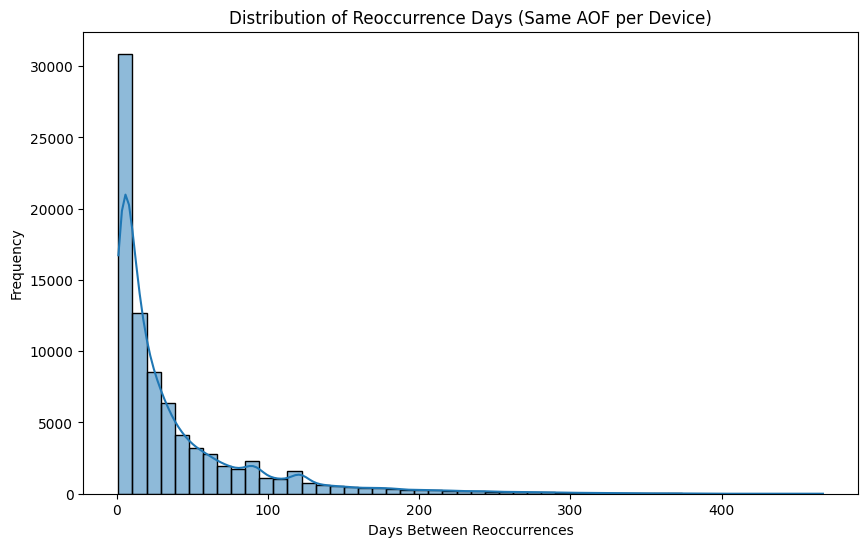

In [51]:
import pandas as pd

# Ensure date column is in datetime format
sr_data['creation_dt_ltz'] = pd.to_datetime(sr_data['creation_dt_ltz'])

# Sort before grouping
sr_data = sr_data.sort_values(by=['final_item_serial_nbr', 'rptg_comb_aof_desc', 'creation_dt_ltz'])

# Calculate reoccurrence days within each device and AOF
sr_data['reoccurrence_days'] = (
    sr_data.groupby(['final_item_serial_nbr', 'rptg_comb_aof_desc'])['creation_dt_ltz']
    .diff()
    .dt.days
)

# Optional: filter valid rows (positive gaps only)
sr_data_valid = sr_data[sr_data['reoccurrence_days'].notna() & (sr_data['reoccurrence_days'] > 0)]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(sr_data_valid['reoccurrence_days'], bins=50, kde=True)
plt.title("Distribution of Reoccurrence Days (Same AOF per Device)")
plt.xlabel("Days Between Reoccurrences")
plt.ylabel("Frequency")
plt.show()


## Overlap summary

In [ ]:
n7data.shape, sr_data.shape, n7data['sr_number'].nunique(), sr_data['sr_nbr'].nunique()

In [ ]:
sr_data.head()

In [ ]:
n7data.head()

In [ ]:
# Step 1: Ensure column types are aligned
sr_data['sr_nbr'] = sr_data['sr_nbr'].astype(str)
n7data['sr_number'] = n7data['sr_number'].astype(str)

sr_data['final_item_serial_nbr'] = sr_data['final_item_serial_nbr'].astype(str)
n7data['serial_number'] = n7data['serial_number'].astype(str)

# Step 2: Merge on SR number
sr_overlap_sr = pd.merge(sr_data, n7data, left_on='sr_nbr', right_on='sr_number', how='inner')
overlap_sr_count = sr_overlap_sr.shape[0]

# Step 4: Merge on both sr_number and serial_number
sr_overlap_both = pd.merge(
    sr_data, n7data,
    left_on=['sr_nbr', 'final_item_serial_nbr'],
    right_on=['sr_number', 'serial_number'],
    how='inner'
)
overlap_both_count = sr_overlap_both.shape[0]

# Step 5: Use sr_data as denominator
sr_total = sr_data.shape[0]
sr_overlap_percent = (overlap_sr_count / sr_total) * 100
both_overlap_percent = (overlap_both_count / sr_total) * 100

# Step 6: Print summary
print("Overlap Summary (using sr_data as denominator):")
print(f"- Total rows in sr_data: {sr_total}")
print(f"- Overlap on sr_number only     : {overlap_sr_count} rows ({sr_overlap_percent:.2f}%)")
# print(f"- Overlap on BOTH sr_number and serial_number: {overlap_both_count} rows ({both_overlap_percent:.2f}%)")
